In [1]:
import tensorflow as tf
import keras.backend as K
from keras.models import model_from_yaml
import numpy as np
import os
import glob
from pybedtools import BedTool
import genomelake
from genomelake.extractors import ArrayExtractor 
from plot import seqlogo_fig

Using TensorFlow backend.
/users/manyu/anaconda3/envs/pwm_utils/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
DEFER_DELETE_SIZE=int(250 * 1e6)
def create_tensorflow_session(visiblegpus):
    os.environ['CUDA_VISIBLE_DEVICES'] = str(visiblegpus)
    session_config = tf.ConfigProto()
    session_config.gpu_options.deferred_deletion_bytes = DEFER_DELETE_SIZE
    session_config.gpu_options.per_process_gpu_memory_fraction = 0.45
    session = tf.Session(config=session_config)
    K.set_session(session)
    return session

sess = create_tensorflow_session(1)

In [3]:
path_to_model = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/seq_meth_AC_models/logdir_0wDEL2/model.arch.yaml'
path_to_model_weights = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/seq_meth_AC_models/logdir_0wDEL2/model.weights.h5'

In [4]:
with open(path_to_model,'r') as f:
    model = model_from_yaml(f)
    model.load_weights(path_to_model_weights)

In [5]:
path_to_intervals = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/label_regions/labeled_intervals/DEL2_DapSeq_bin200_flank400_stride200.TAIR10.intervals.bed'
path_to_labels = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/label_regions/labeled_intervals/DEL2_DapSeq_bin200_flank400_stride200.TAIR10.labels.npy'


In [6]:
intervals_dataframe = BedTool(path_to_intervals).to_dataframe()

In [7]:
labels = np.load(path_to_labels)

In [8]:
pos_indexes = np.where(labels ==1)[0]

In [9]:
pos_indexes

array([    35,    254,    255, ..., 594512, 594726, 594919])

In [10]:
pos_intervals = intervals_dataframe.values[pos_indexes]

In [11]:
if not os.path.exists('./tmp'):
    os.makedirs('./tmp/')
path_to_pos_intervals_file = './tmp/pos_intervals.bed'
with open(path_to_pos_intervals_file,'w') as f:
    for line in pos_intervals:
        f.write(line[0]+'\t'+str(line[1])+'\t'+str(line[2])+'\n')
    f.close()    

In [12]:
path_to_arabidopsis_genome = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/memmaped_bcolz_datasets/TAIR10.fa/'
genome_extractor = ArrayExtractor(path_to_arabidopsis_genome)

In [13]:
path_to_C_methylation = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/memmaped_bcolz_datasets/methylation_dir/Arabidopsis_WGBS-Col-0-GSM1942127.Bismark_v0.19.0/GSM1942127.Bismark_v0.19.0.se.normalized.renamed.bigWig/'
path_to_A_methylation = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/memmaped_bcolz_datasets/methylation_dir/Arabidopsis_6mA_methylation/GSM2157793_Col_6mA_modification.normalized.renamed.bigWig/'
C_meth_extractor  = ArrayExtractor(path_to_C_methylation)
A_meth_extractor = ArrayExtractor(path_to_A_methylation)

In [14]:
pos_intervals_extracted_arr = genome_extractor(BedTool(path_to_pos_intervals_file))
A_methylation = A_meth_extractor(BedTool(path_to_pos_intervals_file))
C_methylation = C_meth_extractor(BedTool(path_to_pos_intervals_file))

In [15]:
print(pos_intervals.shape)
pos_intervals_extracted_arr = np.transpose(pos_intervals_extracted_arr,[0,2,1])
print(pos_intervals.shape)

(1281, 4)
(1281, 4)


In [16]:
pos_intervals_extracted_arr.shape

(1281, 4, 1000)

In [17]:
seq_input = model.get_layer('data/genome_data_dir').input
meth_input_C = model.get_layer('data/methylation_data_dir').input
meth_input_A = model.get_layer('data/A_methylation_data_dir').input
logit = K.sum(model.layers[-2].output,axis = 0)

In [18]:
logit_grad = K.gradients(logit,[seq_input,meth_input_C,meth_input_A])
logit_gradients_func = K.function([seq_input, meth_input_C, meth_input_A,K.learning_phase()], logit_grad)

In [19]:
#ogit_grad_tf = tf.gradients(logit,[seq_input,meth_input_C,meth_input_A])

In [20]:
grad_seq,grad_meth_C,grad_meth_A = logit_gradients_func([pos_intervals_extracted_arr,C_methylation,A_methylation,False])

In [21]:
input_grad_seq = grad_seq*pos_intervals_extracted_arr
input_grad_meth_C  = grad_meth_C*C_methylation
input_grad_meth_A = grad_meth_A*A_methylation

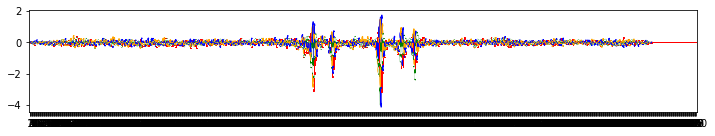

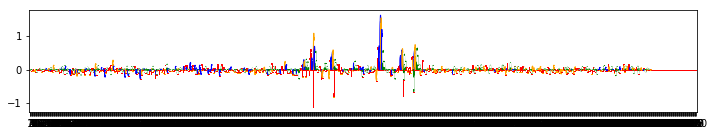

In [22]:
index = 405
lower = 0
upper = 1000
fig = seqlogo_fig(grad_seq[index].transpose()[lower:upper])
fig_input_grad_seq = seqlogo_fig(input_grad_seq[index].transpose()[lower:upper])

In [24]:
c_locations = pos_intervals_extracted_arr[:,1,:]
g_locations = pos_intervals_extracted_arr[:,2,:]
a_locations = pos_intervals_extracted_arr[:,0,:]
t_locations = pos_intervals_extracted_arr[:,3,:]

# c_meth = np.expand_dims(c_locations*extracted_intervals_Cmeth,axis=-1)
# g_meth = np.expand_dims(g_locations*extracted_intervals_Cmeth,axis=-1)
# a_meth = np.expand_dims(a_locations*extracted_intervals_Ameth,axis=-1)
# t_meth = np.expand_dims(t_locations*extracted_intervals_Ameth,axis=-1)
# seq_meth_input = np.concatenate([a_meth,c_meth,extracted_intervals_seq,g_meth,t_meth],axis=-1)

In [25]:
print c_locations.shape

(1281, 1000)


In [26]:
c_scores = np.expand_dims(c_locations*input_grad_meth_C,axis=-1)
g_scores = np.expand_dims(g_locations*input_grad_meth_C,axis=-1)
a_scores = np.expand_dims(a_locations*input_grad_meth_A,axis=-1)
t_scores = np.expand_dims(t_locations*input_grad_meth_A,axis=-1)
seq_scores_input_grad = np.transpose(input_grad_seq,[0,2,1])
concat_scores = np.concatenate([a_scores,c_scores,seq_scores_input_grad,g_scores,t_scores],axis=-1)

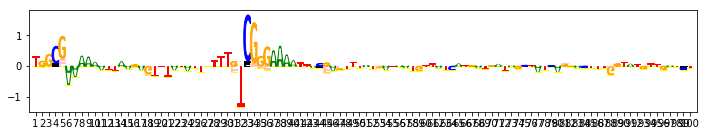

In [27]:
index = 154
lower = 500
upper = 600
fig = seqlogo_fig(concat_scores[index][lower:upper],vocab='Meth_8_channel')


In [28]:
input_grad_seq.shape,input_grad_meth_C.shape

((1281, 4, 1000), (1281, 1000))

In [29]:
meth_c_sums = np.array([np.sum(i) for i in C_methylation])
meth_a_sums = np.array([np.sum(i) for i in A_methylation])

In [30]:
sorted_for_meth_C = np.argsort(meth_c_sums*-1)
sorted_for_meth_A = np.argsort(meth_a_sums*-1)

In [31]:
###Function that calculates the 8 channel input*grad importance score
###Function that calculates the 8 channel gradient score and returns it
###Function that returns the 8 channel sequence in that interval
###After that I need to do the DFIM with methylation, change methylation at some motif locations and
###then look at where on the sequence the things change the most, in terms of the delta importance scores

###Can also just try out a clustering now of the importance scores seqlets with k-means clustering, 
###a mini modisco approach


###It looks that the input*grad scores are tiny for the E,F. This should be compared to a seq based motif


In [32]:
sorted_for_meth_C[0:10]

array([ 635, 1056, 1041,  154,  833,  659,  746, 1054,  498,    2])

In [33]:
def create_8_channel_scores(sequences,scores_seq,scores_meth_C,scores_meth_A):
    assert sequences.shape[1:] == (1000,4)
    assert scores_seq.shape == sequences.shape
    c_locations = sequences[:,:,1]
    g_locations = sequences[:,:,2]
    a_locations = sequences[:,:,0]
    t_locations = sequences[:,:,3]
    print("c_locations shape = {}".format(c_locations.shape))
    print(scores_meth_C.shape)
    
    c_scores = np.expand_dims(c_locations*scores_meth_C,axis=-1)
    g_scores = np.expand_dims(g_locations*scores_meth_C,axis=-1)
    a_scores = np.expand_dims(a_locations*scores_meth_A,axis=-1)
    t_scores = np.expand_dims(t_locations*scores_meth_A,axis=-1)
    concat_scores = np.concatenate([a_scores,c_scores,scores_seq,g_scores,t_scores],axis=-1)
    return concat_scores
    


    

In [34]:
pos_intervals_extracted_arr.shape
input_grad_seq.shape

(1281, 4, 1000)

In [35]:
concat_scores_input_grad = create_8_channel_scores(np.transpose(pos_intervals_extracted_arr,[0,2,1]),
                                       np.transpose(input_grad_seq,[0,2,1]),input_grad_meth_C,
                                       input_grad_meth_A)
concat_scores_grad  = create_8_channel_scores(np.transpose(pos_intervals_extracted_arr,[0,2,1]),
                                             np.transpose(grad_seq,[0,2,1]),grad_meth_C,grad_meth_A)
concat_scores_seq = create_8_channel_scores(np.transpose(pos_intervals_extracted_arr,[0,2,1]),
                                           np.transpose(pos_intervals_extracted_arr,[0,2,1]),
                                           C_methylation,A_methylation)

c_locations shape = (1281, 1000)
(1281, 1000)
c_locations shape = (1281, 1000)
(1281, 1000)
c_locations shape = (1281, 1000)
(1281, 1000)


In [195]:
sorted_for_meth_C[0:10]

array([ 635, 1056, 1041,  154,  833,  659,  746, 1054,  498,    2])

In [196]:
sorted_for_meth_A[0:10]

array([ 682,  314,  557,  787, 1054,  679,  680,  806,  839, 1256])

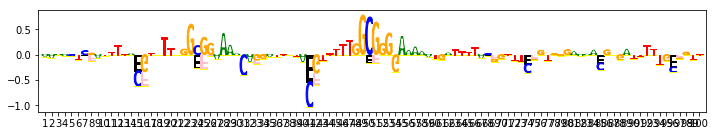

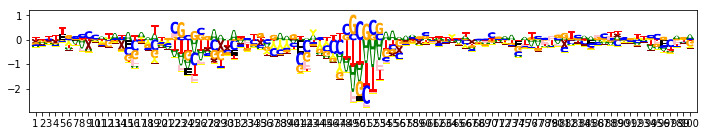

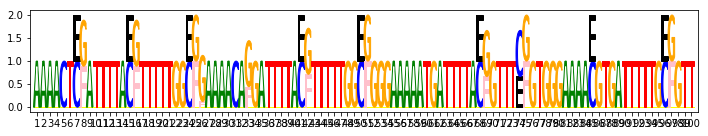

In [36]:
index = 1041
lower = 400
upper = 500
fig_input_grad = seqlogo_fig(concat_scores_input_grad[index][lower:upper],vocab='Meth_8_channel')
fig_grad = seqlogo_fig(concat_scores_grad[index][lower:upper],vocab='Meth_8_channel')
fig_seq = seqlogo_fig(concat_scores_seq[index][lower:upper],vocab='Meth_8_channel')

In [224]:
np.sum(A_methylation[557])

4.1740003

In [222]:
np.where(A_methylation[557]>0)

(array([310, 312, 318, 320, 322, 324]),)

In [1]:
A_methylation[682]

NameError: name 'A_methylation' is not defined